# Emotion Classification by FER-2013


[Dataset FER-2013](https://www.kaggle.com/datasets/msambare/fer2013)

**About Dataset**<br>

The data consists of 48x48 pixel grayscale images of faces. The faces have been automatically registered so that the face is more or less centred and occupies about the same amount of space in each image.

The task is to categorize each face based on the emotion shown in the facial expression into one of seven categories.

|Encode|Class|
|:---:|:---:|
|0|Angry|
|1|Disgust|
|2|Fear|
|3|Happy|
|4|Sad|
|5|Surprise|
|6|Neutral|
 
 
 The training set consists of 28,709 examples and the public test set consists of 3,589 examples.



In [1]:
classnames = [tmp.lower() for tmp in ['Angry','Disgust','Fear','Happy','Sad','Surprise','Neutral']]
print(classnames)

['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']


In [2]:
import json
import os
folder_path_train = './dataset_fer2013/train'
folder_path_test = './dataset_fer2013/test'


imagepaths_train, labels_train=[],[]
for label, tmp_class in enumerate(classnames):
    mypath = os.path.join(folder_path_train, tmp_class)
    filenames = os.listdir(mypath)
    for filename in filenames:
        imagepaths_train.append(os.path.join(mypath, filename))
        labels_train.append(label)
        
imagepaths_test, labels_test=[],[]
for label, tmp_class in enumerate(classnames):
    mypath = os.path.join(folder_path_test, tmp_class)
    filenames = os.listdir(mypath)
    for filename in filenames:
        imagepaths_test.append(os.path.join(mypath, filename))
        labels_test.append(label)

    
print(imagepaths_test[0:5])
print(labels_test[0:5])

data={}
data['imagepaths_train']=imagepaths_train
data['labels_train'] = labels_train
data['imagepaths_test']=imagepaths_test
data['labels_test'] = labels_test
with open('fer_2013.json', 'w', newline='') as jsonfile:
    json.dump(data, jsonfile)
    

['./dataset_fer2013/test\\angry\\PrivateTest_10131363.jpg', './dataset_fer2013/test\\angry\\PrivateTest_10304478.jpg', './dataset_fer2013/test\\angry\\PrivateTest_1054527.jpg', './dataset_fer2013/test\\angry\\PrivateTest_10590091.jpg', './dataset_fer2013/test\\angry\\PrivateTest_1109992.jpg']
[0, 0, 0, 0, 0]


In [3]:
import warnings
warnings.filterwarnings("ignore")
import torch
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import PIL.Image as Image
import numpy as np
import matplotlib.pyplot as plt

class MyDataset(torch.utils.data.Dataset):
    '''
    load the dataset
    '''
    def __init__(self,transforms, isTrain=True):
        with open('fer_2013.json') as jsf:
            data_load = json.load(jsf)
        if isTrain:
            self.imList = data_load['imagepaths_train']
            self.labelList = data_load['labels_train']
            print('number of training data:{}'.format(len(self.imList)))
        else:
            self.imList = data_load['imagepaths_test']
            self.labelList = data_load['labels_test']   
            print('number of test data:{}'.format(len(self.imList)))
        self.transforms=transforms
        
    def __len__(self):
        return len(self.imList)

    def __getitem__(self, idx):
        '''
        :param idx: Index of the image file
        :return: returns the image and corresponding label file.
        '''
        image_name = self.imList[idx]
        label = self.labelList[idx] 
        # read image with PIL module
        image = Image.open(image_name, mode='r')
        image = image.convert('RGB')
        # Convert PIL label image to torch.Tensor
        image = self.transforms(image)
        label = torch.tensor(label)
        return image, label
    def my_collate(batch):
        data, targets = list(), list()
        for b in batch:
            data.append(b[0])
            targets.append(b[1])
        data = torch.stack(data,dim=0)
        targets = torch.stack(targets,dim=0)
        return data, targets
    
if __name__ == "__main__":
    mytransform = transforms.Compose([
            transforms.Resize((48,48)),
            transforms.ToTensor()
            ])
    mydataset = MyDataset(transforms=mytransform, isTrain=True)
    mydata_loader = torch.utils.data.DataLoader(mydataset, batch_size=10, num_workers=0)
    for data in mydata_loader:
        print(data[0].size())
        print(data[1].size())
        break    


number of training data:28709
torch.Size([10, 3, 48, 48])
torch.Size([10])


In [4]:
# Define CNN model
class ConvM(nn.Sequential):
    def __init__(self, in_planes, out_planes, kernel_size=3, stride=1, groups=1):
        padding = (kernel_size - 1) // 2
        norm_layer = nn.BatchNorm2d
        super(ConvM, self).__init__(
            nn.Conv2d(in_planes, out_planes, kernel_size, stride, padding, groups=groups, bias=False),
            norm_layer(out_planes),
            nn.ReLU(inplace=True),
        )
class ConvNet(nn.Module):
    def __init__(self, n_class):
        super(ConvNet, self).__init__()
        
        self.conv = nn.Sequential(
            ConvM(3, 32, 5, 2),
            ConvM(32, 64, 5, 2),
            ConvM(64, 128, 3, 1),
            ConvM(128, 64, 3, 1),
            ConvM(64, 32, 3, 1),
        )        
        self.fc = nn.Linear(32, n_class)
    def forward(self, x):
        x = self.conv(x)
        x = nn.functional.adaptive_avg_pool2d(x, 1).reshape(x.shape[0], -1)
        ft = x
        output = self.fc(x)
        return output
    
    
def conv3x3(in_planes: int, out_planes: int, stride: int = 1, groups: int = 1, dilation: int = 1) -> nn.Conv2d:
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)

def conv1x1(in_planes: int, out_planes: int, stride: int = 1) -> nn.Conv2d:
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

class RESNET18(nn.Module):
    def __init__(self, num_classes=10):
        super(RESNET18, self).__init__()
        # _resnet('resnet18', BasicBlock, [2, 2, 2, 2])
        channel_ration = 0.1

        norm_layer = nn.BatchNorm2d
        outch =  int(64 * channel_ration)
        self.conv1 = nn.Conv2d(3, outch, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = norm_layer(outch)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        '''
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        '''

        # layer 1
        outch =  int(64 * channel_ration)
        self.l1_p1_conv1 = conv3x3(outch, outch, 1)
        self.l1_p1_bn1 = norm_layer(outch)
        self.l1_relu = nn.ReLU(inplace=True)
        self.l1_p1_conv2 = conv3x3(outch, outch)
        self.l1_p1_bn2 = norm_layer(outch)
        
        self.l1_p2_conv1 = conv3x3(outch, outch, 1)
        self.l1_p2_bn1 = norm_layer(outch)
        self.l1_p2_relu = nn.ReLU(inplace=True)
        self.l1_p2_conv2 = conv3x3(outch, outch)
        self.l1_p2_bn2 = norm_layer(outch)
        
         # layer 2
        inch =  int(64 * channel_ration)
        outch =  int(128 * channel_ration)
        self.downsample2 = nn.Sequential(
                conv1x1(inch, outch, 2),
                norm_layer(outch),
            )
        self.l2_p1_conv1 = conv3x3(inch, outch, 2)
        self.l2_p1_bn1 = norm_layer(outch)
        self.l2_relu = nn.ReLU(inplace=True)
        self.l2_p1_conv2 = conv3x3(outch, outch)
        self.l2_p1_bn2 = norm_layer(outch)
        
        self.l2_p2_conv1 = conv3x3(outch, outch, 1)
        self.l2_p2_bn1 = norm_layer(outch)
        self.l2_p2_relu = nn.ReLU(inplace=True)
        self.l2_p2_conv2 = conv3x3(outch, outch)
        self.l2_p2_bn2 = norm_layer(outch)
        
        # layer 3
        inch =  int(128 * channel_ration)
        outch =  int(256 * channel_ration)
        self.downsample3 = nn.Sequential(
                conv1x1(inch, outch, 2),
                norm_layer(outch),
            )    
        self.l3_p1_conv1 = conv3x3(inch, outch, 2)
        self.l3_p1_bn1 = norm_layer(outch)
        self.l3_relu = nn.ReLU(inplace=True)
        self.l3_p1_conv2 = conv3x3(outch, outch)
        self.l3_p1_bn2 = norm_layer(outch)
        
        self.l3_p2_conv1 = conv3x3(outch, outch, 1)
        self.l3_p2_bn1 = norm_layer(outch)
        self.l3_p2_relu = nn.ReLU(inplace=True)
        self.l3_p2_conv2 = conv3x3(outch, outch)
        self.l3_p2_bn2 = norm_layer(outch)
        
        # layer 4
        inch =  int(256 * channel_ration)
        outch =  int(512 * channel_ration)
        self.downsample4 = nn.Sequential(
                conv1x1(inch, outch, 2),
                norm_layer(outch),
            )     
        self.l4_p1_conv1 = conv3x3(inch, outch, 2)
        self.l4_p1_bn1 = norm_layer(outch)
        self.l4_relu = nn.ReLU(inplace=True)
        self.l4_p1_conv2 = conv3x3(outch, outch)
        self.l4_p1_bn2 = norm_layer(outch)
        
        self.l4_p2_conv1 = conv3x3(outch, outch, 1)
        self.l4_p2_bn1 = norm_layer(outch)
        self.l4_p2_relu = nn.ReLU(inplace=True)
        self.l4_p2_conv2 = conv3x3(outch, outch)
        self.l4_p2_bn2 = norm_layer(outch)
   
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(outch , num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):    
        # 1
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
                
        # 2,3
        identity11 = x
        x = self.l1_p1_conv1(x)
        x = self.l1_p1_bn1(x)
        x = self.l1_relu(x)
        x = self.l1_p1_conv2(x)
        x = self.l1_p1_bn2(x)
        x += identity11
        x = self.l1_relu(x)
        # 4,5
        identity12 = x
        x = self.l1_p2_conv1(x)
        x = self.l1_p2_bn1(x)
        x = self.l1_p2_relu(x)
        x = self.l1_p2_conv2(x)
        x = self.l1_p2_bn2(x)
        x += identity12
        x = self.l1_p2_relu(x)
        
        
        # 6,7
        identity21 = self.downsample2(x)
        x = self.l2_p1_conv1(x)
        x = self.l2_p1_bn1(x)
        x = self.l2_relu(x)
        x = self.l2_p1_conv2(x)
        x = self.l2_p1_bn2(x)
        x += identity21
        x = self.l2_relu(x)
        # 8,9
        identity22 = x
        x = self.l2_p2_conv1(x)
        x = self.l2_p2_bn1(x)
        x = self.l2_p2_relu(x)
        x = self.l2_p2_conv2(x)
        x = self.l2_p2_bn2(x)
        x += identity22
        x = self.l2_p2_relu(x)
        
        
        # 10,11
        identity31 = self.downsample3(x)
        x = self.l3_p1_conv1(x)
        x = self.l3_p1_bn1(x)
        x = self.l3_relu(x)
        x = self.l3_p1_conv2(x)
        x = self.l3_p1_bn2(x)
        x += identity31
        x = self.l3_relu(x)
        # 12,13
        identity32 = x
        x = self.l3_p2_conv1(x)
        x = self.l3_p2_bn1(x)
        x = self.l3_p2_relu(x)
        x = self.l3_p2_conv2(x)
        x = self.l3_p2_bn2(x)
        x += identity32
        x = self.l3_p2_relu(x)
        
                # 14,15
        identity41 = self.downsample4(x)
        x = self.l4_p1_conv1(x)
        x = self.l4_p1_bn1(x)
        x = self.l4_relu(x)
        x = self.l4_p1_conv2(x)
        x = self.l4_p1_bn2(x)
        x += identity41
        x = self.l4_relu(x)
        
        # 16,17
        identity42 = x
        x = self.l4_p2_conv1(x)
        x = self.l4_p2_bn1(x)
        x = self.l4_p2_relu(x)
        x = self.l4_p2_conv2(x)
        x = self.l4_p2_bn2(x)
        x += identity42
        x = self.l4_p2_relu(x)
        
        x = self.avgpool(x)
        x = x.view(x.size(0),-1)
        x = self.fc(x)
        return x
    

In [6]:
from tqdm import tqdm

def evalmodel(model, testloader, loss):
    model.eval()
    test_loss_cnn = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(testloader):
            data, target = data.to(device), target.to(device)
            output_cnn = model(data)
            loss_cnn = loss(output_cnn,target)  
            
            test_loss_cnn += loss_cnn*len(target)
            _, predicted = torch.max(output_cnn.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
        # the class with the highest energy is what we choose as prediction
    test_loss_cnn /= len(testloader)
    acc = 100 * correct / total
    return test_loss_cnn, acc

def train(model_cnn, loss, optimizer_cnn, scheduler):  
    log_loss_train=[]
    log_loss_test=[]
    for epoch in range(total_epoch):
        scheduler.step()
        print('Epoch:{}'.format(epoch))
        # train
        model_cnn.train()
        loss_train = 0
        for batch_idx, (data, target) in tqdm(enumerate(dataloader_train)):
            data, target = data.to(device), target.to(device)
            optimizer_cnn.zero_grad()
            output_cnn = model_cnn(data)
            loss_cnn = loss(output_cnn,target)  
            loss_cnn.backward()
            optimizer_cnn.step()
#             loss_train += loss_cnn*len(target)
#         loss_train /= len(dataset_train)

        # test
        if epoch % 1 == 0:
            train_loss, train_acc= evalmodel(model_cnn, dataloader_train, loss)
            test_loss, test_acc= evalmodel(model_cnn, dataloader_test, loss)
            log_loss_train.append(train_loss)
            log_loss_test.append(test_loss)
            print('learning rate:{}'.format(scheduler.get_last_lr()[0]))
            print('epoch: {}/{}, Average loss (Train):{:.5f}, Average loss (test):{:.5f}, acc(train):{:.4f}, acc(test):{:.4f}'.format(
                epoch+1, total_epoch, train_loss, test_loss, train_acc, test_acc))
        
    print('training done.')
    return model_cnn, log_loss_train, log_loss_test
# 步驟0. 是否使用CUDA 
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1" 
use_cuda = 1
device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")
print(device)
##############

total_epoch=100
lr = 0.001
batch_size=256
num_workers=0

# 步驟1. data loader處理 
mytransform_woDA = transforms.Compose([
            transforms.Resize((48,48)),
            transforms.ToTensor()
            ])

transform_set = [ 
            transforms.RandomCrop(32, padding=4),
            transforms.RandomRotation(degrees=(-15,15)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.ColorJitter(brightness=(0.8, 1.3), contrast=(
                        0.8, 1.3), saturation=(.8, 1.3), hue=(-0.1, 0.1))
]
mytransform_wDA = transforms.Compose([
                            transforms.RandomApply(transform_set, p=0.5),
                            transforms.Resize((48,48)),
                            transforms.ToTensor()])

dataset_train = MyDataset(transforms=mytransform_wDA, isTrain=True)
dataset_test = MyDataset(transforms=mytransform_woDA, isTrain=False)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, num_workers=num_workers,shuffle=True)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, num_workers=num_workers,shuffle=False)
# initialize the ConvNet
# model_cnn = ConvNet(n_class=7).to(device)
model_cnn = RESNET18(num_classes=7).to(device)

# 步驟3. loss function宣告
loss = torch.nn.CrossEntropyLoss().to(device)
# 步驟4. optimator宣告
optimizer_cnn = optim.Adam(model_cnn.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer_cnn, milestones=[20,40,60,80], gamma=0.1)

print('total training iter:{}'.format(len(dataloader_train)))
print('total test iter:{}'.format(len(dataloader_test)))   

# 步驟5. CNN模型開始訓練
model_cnn, log_loss_train, log_loss_test = train(model_cnn, loss, optimizer_cnn, scheduler)
checkpoint={}
checkpoint['log_loss_train']=log_loss_train
checkpoint['log_loss_test']=log_loss_test
checkpoint['model_dict'] = model_cnn.state_dict()
torch.save(checkpoint, 'Model_resnet18_fer2013_scheduler.pth')
print('Model saved.')

cuda
number of training data:28709
number of test data:7178
total training iter:113
total test iter:29
Epoch:0


113it [00:21,  5.20it/s]


learning rate:0.001
epoch: 1/100, Average loss (Train):1.77047, Average loss (test):0.43453, acc(train):26.9463, acc(test):29.1725
Epoch:1


113it [00:20,  5.46it/s]


learning rate:0.001
epoch: 2/100, Average loss (Train):1.73806, Average loss (test):0.42434, acc(train):28.8098, acc(test):31.4990
Epoch:2


113it [00:20,  5.41it/s]


learning rate:0.001
epoch: 3/100, Average loss (Train):1.71473, Average loss (test):0.41368, acc(train):30.1961, acc(test):33.3658
Epoch:3


113it [00:21,  5.35it/s]


learning rate:0.001
epoch: 4/100, Average loss (Train):1.70931, Average loss (test):0.41313, acc(train):30.2309, acc(test):34.0206
Epoch:4


113it [00:20,  5.44it/s]


learning rate:0.001
epoch: 5/100, Average loss (Train):1.70458, Average loss (test):0.41187, acc(train):30.4295, acc(test):34.4386
Epoch:5


113it [00:20,  5.42it/s]


learning rate:0.001
epoch: 6/100, Average loss (Train):1.66193, Average loss (test):0.39469, acc(train):32.7354, acc(test):37.8936
Epoch:6


113it [00:20,  5.45it/s]


learning rate:0.001
epoch: 7/100, Average loss (Train):1.70771, Average loss (test):0.40223, acc(train):33.1185, acc(test):38.4787
Epoch:7


113it [00:20,  5.45it/s]


learning rate:0.001
epoch: 8/100, Average loss (Train):1.63344, Average loss (test):0.38217, acc(train):34.7104, acc(test):39.4957
Epoch:8


113it [00:20,  5.44it/s]


learning rate:0.001
epoch: 9/100, Average loss (Train):1.64364, Average loss (test):0.39203, acc(train):34.0102, acc(test):37.6010
Epoch:9


113it [00:20,  5.44it/s]


learning rate:0.001
epoch: 10/100, Average loss (Train):1.67013, Average loss (test):0.39755, acc(train):34.2192, acc(test):38.4648
Epoch:10


113it [00:20,  5.45it/s]


learning rate:0.001
epoch: 11/100, Average loss (Train):1.60976, Average loss (test):0.38385, acc(train):35.2851, acc(test):39.6768
Epoch:11


113it [00:20,  5.41it/s]


learning rate:0.001
epoch: 12/100, Average loss (Train):1.59706, Average loss (test):0.37473, acc(train):35.8947, acc(test):41.9755
Epoch:12


113it [00:20,  5.46it/s]


learning rate:0.001
epoch: 13/100, Average loss (Train):1.58347, Average loss (test):0.37962, acc(train):37.0894, acc(test):40.9306
Epoch:13


113it [00:20,  5.45it/s]


learning rate:0.001
epoch: 14/100, Average loss (Train):1.53916, Average loss (test):0.36748, acc(train):38.3329, acc(test):42.2402
Epoch:14


113it [00:20,  5.45it/s]


learning rate:0.001
epoch: 15/100, Average loss (Train):1.55722, Average loss (test):0.36903, acc(train):38.4618, acc(test):43.0900
Epoch:15


113it [00:21,  5.36it/s]


learning rate:0.001
epoch: 16/100, Average loss (Train):1.55183, Average loss (test):0.37929, acc(train):38.3991, acc(test):41.7247
Epoch:16


113it [00:20,  5.43it/s]


learning rate:0.001
epoch: 17/100, Average loss (Train):1.49097, Average loss (test):0.36128, acc(train):41.4260, acc(test):43.8005
Epoch:17


113it [00:20,  5.39it/s]


learning rate:0.001
epoch: 18/100, Average loss (Train):1.49229, Average loss (test):0.36220, acc(train):41.0429, acc(test):43.2990
Epoch:18


113it [00:20,  5.40it/s]


learning rate:0.001
epoch: 19/100, Average loss (Train):1.46909, Average loss (test):0.36032, acc(train):42.1087, acc(test):45.0961
Epoch:19


113it [00:20,  5.42it/s]


learning rate:0.0001
epoch: 20/100, Average loss (Train):1.42432, Average loss (test):0.35195, acc(train):44.1604, acc(test):45.5280
Epoch:20


113it [00:20,  5.43it/s]


learning rate:0.0001
epoch: 21/100, Average loss (Train):1.42011, Average loss (test):0.35336, acc(train):44.7630, acc(test):45.7648
Epoch:21


113it [00:20,  5.40it/s]


learning rate:0.0001
epoch: 22/100, Average loss (Train):1.40838, Average loss (test):0.35459, acc(train):45.0381, acc(test):46.0156
Epoch:22


113it [00:20,  5.45it/s]


learning rate:0.0001
epoch: 23/100, Average loss (Train):1.40004, Average loss (test):0.35427, acc(train):45.2750, acc(test):45.6952
Epoch:23


113it [00:21,  5.35it/s]


learning rate:0.0001
epoch: 24/100, Average loss (Train):1.39740, Average loss (test):0.35565, acc(train):45.5502, acc(test):45.8624
Epoch:24


113it [00:20,  5.41it/s]


learning rate:0.0001
epoch: 25/100, Average loss (Train):1.39054, Average loss (test):0.35638, acc(train):46.0483, acc(test):45.8763
Epoch:25


113it [00:20,  5.46it/s]


learning rate:0.0001
epoch: 26/100, Average loss (Train):1.38722, Average loss (test):0.35763, acc(train):45.7104, acc(test):46.0156
Epoch:26


113it [00:20,  5.45it/s]


learning rate:0.0001
epoch: 27/100, Average loss (Train):1.39833, Average loss (test):0.36169, acc(train):45.3690, acc(test):45.2354
Epoch:27


113it [00:27,  4.16it/s]


learning rate:0.0001
epoch: 28/100, Average loss (Train):1.37288, Average loss (test):0.35843, acc(train):46.7171, acc(test):45.5559
Epoch:28


113it [00:21,  5.36it/s]


learning rate:0.0001
epoch: 29/100, Average loss (Train):1.38355, Average loss (test):0.36234, acc(train):46.0483, acc(test):45.3190
Epoch:29


113it [00:20,  5.42it/s]


learning rate:0.0001
epoch: 30/100, Average loss (Train):1.38042, Average loss (test):0.36421, acc(train):46.0518, acc(test):45.2772
Epoch:30


113it [00:20,  5.41it/s]


learning rate:0.0001
epoch: 31/100, Average loss (Train):1.37077, Average loss (test):0.36157, acc(train):46.8355, acc(test):46.0713
Epoch:31


113it [00:20,  5.42it/s]


learning rate:0.0001
epoch: 32/100, Average loss (Train):1.36285, Average loss (test):0.36375, acc(train):47.2221, acc(test):45.6395
Epoch:32


113it [00:20,  5.41it/s]


learning rate:0.0001
epoch: 33/100, Average loss (Train):1.36535, Average loss (test):0.36354, acc(train):47.1490, acc(test):46.0435
Epoch:33


113it [00:20,  5.41it/s]


learning rate:0.0001
epoch: 34/100, Average loss (Train):1.36327, Average loss (test):0.36527, acc(train):46.8982, acc(test):45.7927
Epoch:34


113it [00:20,  5.40it/s]


learning rate:0.0001
epoch: 35/100, Average loss (Train):1.36199, Average loss (test):0.36543, acc(train):47.1943, acc(test):45.8345
Epoch:35


113it [00:20,  5.45it/s]


learning rate:0.0001
epoch: 36/100, Average loss (Train):1.35030, Average loss (test):0.36463, acc(train):47.9675, acc(test):45.7091
Epoch:36


113it [00:20,  5.41it/s]


learning rate:0.0001
epoch: 37/100, Average loss (Train):1.34620, Average loss (test):0.36647, acc(train):48.0024, acc(test):45.8206
Epoch:37


113it [00:20,  5.45it/s]


learning rate:0.0001
epoch: 38/100, Average loss (Train):1.35068, Average loss (test):0.36769, acc(train):47.7934, acc(test):45.9181
Epoch:38


113it [00:20,  5.43it/s]


learning rate:0.0001
epoch: 39/100, Average loss (Train):1.33925, Average loss (test):0.36789, acc(train):47.8805, acc(test):46.0713
Epoch:39


113it [00:20,  5.45it/s]


learning rate:1e-05
epoch: 40/100, Average loss (Train):1.33039, Average loss (test):0.36899, acc(train):48.6154, acc(test):45.7370
Epoch:40


113it [00:20,  5.46it/s]


learning rate:1e-05
epoch: 41/100, Average loss (Train):1.33352, Average loss (test):0.36723, acc(train):48.5980, acc(test):45.6952
Epoch:41


113it [00:20,  5.43it/s]


learning rate:1e-05
epoch: 42/100, Average loss (Train):1.33526, Average loss (test):0.36863, acc(train):48.3159, acc(test):45.7788
Epoch:42


113it [00:20,  5.45it/s]


learning rate:1e-05
epoch: 43/100, Average loss (Train):1.33597, Average loss (test):0.36832, acc(train):48.1905, acc(test):45.9320
Epoch:43


113it [00:20,  5.43it/s]


learning rate:1e-05
epoch: 44/100, Average loss (Train):1.33790, Average loss (test):0.36913, acc(train):48.2706, acc(test):45.8206
Epoch:44


113it [00:20,  5.42it/s]


learning rate:1e-05
epoch: 45/100, Average loss (Train):1.33010, Average loss (test):0.37218, acc(train):48.6224, acc(test):46.0017
Epoch:45


113it [00:20,  5.38it/s]


learning rate:1e-05
epoch: 46/100, Average loss (Train):1.33348, Average loss (test):0.36954, acc(train):48.5179, acc(test):45.6116
Epoch:46


113it [00:23,  4.82it/s]


learning rate:1e-05
epoch: 47/100, Average loss (Train):1.33134, Average loss (test):0.37040, acc(train):48.4935, acc(test):45.8624
Epoch:47


113it [00:23,  4.80it/s]


learning rate:1e-05
epoch: 48/100, Average loss (Train):1.33072, Average loss (test):0.37066, acc(train):48.7304, acc(test):45.7927
Epoch:48


113it [00:21,  5.34it/s]


learning rate:1e-05
epoch: 49/100, Average loss (Train):1.33568, Average loss (test):0.37006, acc(train):48.3681, acc(test):45.7230
Epoch:49


113it [00:21,  5.38it/s]


learning rate:1e-05
epoch: 50/100, Average loss (Train):1.33664, Average loss (test):0.36860, acc(train):48.2427, acc(test):45.7788
Epoch:50


113it [00:22,  5.10it/s]


learning rate:1e-05
epoch: 51/100, Average loss (Train):1.33636, Average loss (test):0.36963, acc(train):48.4482, acc(test):45.8345
Epoch:51


113it [00:20,  5.47it/s]


learning rate:1e-05
epoch: 52/100, Average loss (Train):1.32914, Average loss (test):0.37007, acc(train):48.6224, acc(test):45.9181
Epoch:52


113it [00:20,  5.45it/s]


learning rate:1e-05
epoch: 53/100, Average loss (Train):1.33227, Average loss (test):0.37092, acc(train):48.2497, acc(test):45.9181
Epoch:53


113it [00:20,  5.47it/s]


learning rate:1e-05
epoch: 54/100, Average loss (Train):1.33507, Average loss (test):0.37099, acc(train):48.1452, acc(test):45.8066
Epoch:54


113it [00:20,  5.48it/s]


learning rate:1e-05
epoch: 55/100, Average loss (Train):1.32552, Average loss (test):0.36960, acc(train):48.9986, acc(test):45.9599
Epoch:55


113it [00:20,  5.47it/s]


learning rate:1e-05
epoch: 56/100, Average loss (Train):1.32964, Average loss (test):0.37101, acc(train):48.7513, acc(test):45.7509
Epoch:56


113it [00:20,  5.43it/s]


learning rate:1e-05
epoch: 57/100, Average loss (Train):1.33439, Average loss (test):0.36995, acc(train):48.3995, acc(test):45.9181
Epoch:57


113it [00:20,  5.42it/s]


learning rate:1e-05
epoch: 58/100, Average loss (Train):1.32593, Average loss (test):0.37038, acc(train):48.7338, acc(test):45.9320
Epoch:58


113it [00:20,  5.44it/s]


learning rate:1e-05
epoch: 59/100, Average loss (Train):1.32753, Average loss (test):0.37132, acc(train):48.7896, acc(test):46.0156
Epoch:59


113it [00:20,  5.38it/s]


learning rate:1.0000000000000002e-06
epoch: 60/100, Average loss (Train):1.33033, Average loss (test):0.37043, acc(train):48.7025, acc(test):45.8624
Epoch:60


113it [00:20,  5.43it/s]


learning rate:1.0000000000000002e-06
epoch: 61/100, Average loss (Train):1.32940, Average loss (test):0.37124, acc(train):48.7931, acc(test):46.0017
Epoch:61


113it [00:20,  5.39it/s]


learning rate:1.0000000000000002e-06
epoch: 62/100, Average loss (Train):1.32473, Average loss (test):0.37029, acc(train):48.7791, acc(test):45.7648
Epoch:62


113it [00:20,  5.42it/s]


learning rate:1.0000000000000002e-06
epoch: 63/100, Average loss (Train):1.33216, Average loss (test):0.37018, acc(train):48.4134, acc(test):45.7648
Epoch:63


113it [00:20,  5.44it/s]


learning rate:1.0000000000000002e-06
epoch: 64/100, Average loss (Train):1.32885, Average loss (test):0.36926, acc(train):48.6189, acc(test):45.8484
Epoch:64


113it [00:20,  5.41it/s]


learning rate:1.0000000000000002e-06
epoch: 65/100, Average loss (Train):1.32801, Average loss (test):0.37034, acc(train):49.0682, acc(test):46.0017
Epoch:65


113it [00:21,  5.35it/s]


learning rate:1.0000000000000002e-06
epoch: 66/100, Average loss (Train):1.32743, Average loss (test):0.36912, acc(train):48.4308, acc(test):46.0156
Epoch:66


113it [00:24,  4.66it/s]


learning rate:1.0000000000000002e-06
epoch: 67/100, Average loss (Train):1.32812, Average loss (test):0.37078, acc(train):48.6363, acc(test):45.9320
Epoch:67


113it [00:23,  4.79it/s]


learning rate:1.0000000000000002e-06
epoch: 68/100, Average loss (Train):1.33197, Average loss (test):0.36920, acc(train):48.7199, acc(test):45.6952
Epoch:68


113it [00:22,  5.00it/s]


learning rate:1.0000000000000002e-06
epoch: 69/100, Average loss (Train):1.32532, Average loss (test):0.37018, acc(train):48.5597, acc(test):45.9877
Epoch:69


113it [00:21,  5.25it/s]


learning rate:1.0000000000000002e-06
epoch: 70/100, Average loss (Train):1.32214, Average loss (test):0.37100, acc(train):48.9045, acc(test):45.9877
Epoch:70


113it [00:20,  5.44it/s]


learning rate:1.0000000000000002e-06
epoch: 71/100, Average loss (Train):1.32838, Average loss (test):0.36864, acc(train):48.8140, acc(test):45.8763
Epoch:71


113it [00:20,  5.43it/s]


learning rate:1.0000000000000002e-06
epoch: 72/100, Average loss (Train):1.32143, Average loss (test):0.37175, acc(train):48.9463, acc(test):45.9877
Epoch:72


113it [00:20,  5.41it/s]


learning rate:1.0000000000000002e-06
epoch: 73/100, Average loss (Train):1.32467, Average loss (test):0.36973, acc(train):48.9185, acc(test):45.7648
Epoch:73


113it [00:20,  5.41it/s]


learning rate:1.0000000000000002e-06
epoch: 74/100, Average loss (Train):1.32301, Average loss (test):0.37162, acc(train):48.8941, acc(test):45.8345
Epoch:74


113it [00:20,  5.42it/s]


learning rate:1.0000000000000002e-06
epoch: 75/100, Average loss (Train):1.32619, Average loss (test):0.37037, acc(train):48.9219, acc(test):45.4305
Epoch:75


113it [00:20,  5.43it/s]


learning rate:1.0000000000000002e-06
epoch: 76/100, Average loss (Train):1.33342, Average loss (test):0.36944, acc(train):48.5492, acc(test):45.6952
Epoch:76


113it [00:20,  5.47it/s]


learning rate:1.0000000000000002e-06
epoch: 77/100, Average loss (Train):1.32388, Average loss (test):0.37089, acc(train):48.6293, acc(test):45.9599
Epoch:77


113it [00:20,  5.46it/s]


learning rate:1.0000000000000002e-06
epoch: 78/100, Average loss (Train):1.32151, Average loss (test):0.37125, acc(train):49.1727, acc(test):45.9599
Epoch:78


113it [00:20,  5.43it/s]


learning rate:1.0000000000000002e-06
epoch: 79/100, Average loss (Train):1.31823, Average loss (test):0.37146, acc(train):49.3399, acc(test):45.8902
Epoch:79


113it [00:20,  5.45it/s]


learning rate:1.0000000000000002e-07
epoch: 80/100, Average loss (Train):1.32248, Average loss (test):0.36997, acc(train):48.9951, acc(test):46.1131
Epoch:80


113it [00:20,  5.47it/s]


learning rate:1.0000000000000002e-07
epoch: 81/100, Average loss (Train):1.32863, Average loss (test):0.37015, acc(train):48.9428, acc(test):45.8484
Epoch:81


113it [00:20,  5.45it/s]


learning rate:1.0000000000000002e-07
epoch: 82/100, Average loss (Train):1.32588, Average loss (test):0.37188, acc(train):48.4656, acc(test):45.9599
Epoch:82


113it [00:20,  5.43it/s]


learning rate:1.0000000000000002e-07
epoch: 83/100, Average loss (Train):1.32633, Average loss (test):0.37224, acc(train):48.6886, acc(test):45.9877
Epoch:83


113it [00:20,  5.45it/s]


learning rate:1.0000000000000002e-07
epoch: 84/100, Average loss (Train):1.32357, Average loss (test):0.36993, acc(train):48.8000, acc(test):45.7230
Epoch:84


113it [00:20,  5.44it/s]


learning rate:1.0000000000000002e-07
epoch: 85/100, Average loss (Train):1.33258, Average loss (test):0.36891, acc(train):48.7129, acc(test):45.9181
Epoch:85


113it [00:20,  5.43it/s]


learning rate:1.0000000000000002e-07
epoch: 86/100, Average loss (Train):1.32519, Average loss (test):0.37165, acc(train):48.9359, acc(test):45.8763
Epoch:86


113it [00:20,  5.44it/s]


learning rate:1.0000000000000002e-07
epoch: 87/100, Average loss (Train):1.32477, Average loss (test):0.37064, acc(train):49.0055, acc(test):45.7230
Epoch:87


113it [00:20,  5.43it/s]


learning rate:1.0000000000000002e-07
epoch: 88/100, Average loss (Train):1.33173, Average loss (test):0.37069, acc(train):48.5736, acc(test):45.6673
Epoch:88


113it [00:20,  5.45it/s]


learning rate:1.0000000000000002e-07
epoch: 89/100, Average loss (Train):1.32685, Average loss (test):0.37147, acc(train):49.1832, acc(test):45.7788
Epoch:89


113it [00:20,  5.43it/s]


learning rate:1.0000000000000002e-07
epoch: 90/100, Average loss (Train):1.32102, Average loss (test):0.37205, acc(train):48.8976, acc(test):45.8763
Epoch:90


113it [00:20,  5.45it/s]


learning rate:1.0000000000000002e-07
epoch: 91/100, Average loss (Train):1.32581, Average loss (test):0.37171, acc(train):48.7547, acc(test):45.5837
Epoch:91


113it [00:20,  5.41it/s]


learning rate:1.0000000000000002e-07
epoch: 92/100, Average loss (Train):1.32405, Average loss (test):0.37091, acc(train):49.0160, acc(test):45.8206
Epoch:92


113it [00:20,  5.45it/s]


learning rate:1.0000000000000002e-07
epoch: 93/100, Average loss (Train):1.32756, Average loss (test):0.37218, acc(train):48.4378, acc(test):45.9181
Epoch:93


113it [00:20,  5.44it/s]


learning rate:1.0000000000000002e-07
epoch: 94/100, Average loss (Train):1.32763, Average loss (test):0.36908, acc(train):48.8488, acc(test):45.7509
Epoch:94


113it [00:20,  5.43it/s]


learning rate:1.0000000000000002e-07
epoch: 95/100, Average loss (Train):1.33154, Average loss (test):0.36999, acc(train):48.7095, acc(test):45.8066
Epoch:95


113it [00:20,  5.44it/s]


learning rate:1.0000000000000002e-07
epoch: 96/100, Average loss (Train):1.32378, Average loss (test):0.37125, acc(train):48.9777, acc(test):45.8484
Epoch:96


113it [00:20,  5.43it/s]


learning rate:1.0000000000000002e-07
epoch: 97/100, Average loss (Train):1.32167, Average loss (test):0.36994, acc(train):49.1971, acc(test):45.8345
Epoch:97


113it [00:20,  5.45it/s]


learning rate:1.0000000000000002e-07
epoch: 98/100, Average loss (Train):1.32482, Average loss (test):0.37141, acc(train):48.5562, acc(test):45.7927
Epoch:98


113it [00:20,  5.46it/s]


learning rate:1.0000000000000002e-07
epoch: 99/100, Average loss (Train):1.32470, Average loss (test):0.37009, acc(train):48.8871, acc(test):46.0156
Epoch:99


113it [00:20,  5.43it/s]


learning rate:1.0000000000000002e-07
epoch: 100/100, Average loss (Train):1.32328, Average loss (test):0.37225, acc(train):49.1309, acc(test):45.9181
training done.
Model saved.


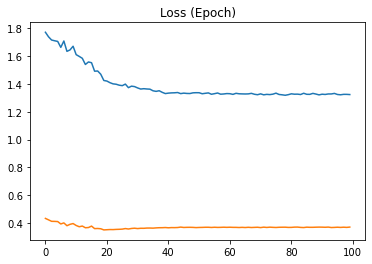

In [7]:

plt.plot([tmp.cpu().detach().numpy()  for tmp in log_loss_train])
plt.plot([tmp.cpu().detach().numpy()  for tmp in log_loss_test])
plt.title('Loss (Epoch)')
plt.show()

In [ ]:

# mytransform = transforms.Compose([
#         transforms.Resize((28,28)),
#         transforms.ToTensor()
#         ])
# model_mlp.eval()  
# model_cnn.eval() 
# #114_100.jpg#
# #123_100.jpg#
# #r_176_100.jpg#
# image_names = ['./dataset/Example_fruit/Test/114_100.jpg',
#               './dataset/Example_fruit/Test/123_100.jpg',
#               './dataset/Example_fruit/Test/r_176_100.jpg']
# for image_name in image_names:
#     image = Image.open(image_name, mode='r')
#     image = image.convert('RGB')
#     plt.imshow(image)
#     plt.show()
    
#     image = mytransform(image)
#     print(image.shape)
#     with torch.no_grad():
#         output_mlp = model_mlp(torch.squeeze(image))
#         output_cnn = model_cnn(torch.unsqueeze(image,dim=0).to(device))
#     output_mlp= F.softmax(output_mlp)
#     output_cnn= F.softmax(output_cnn)

#     list_class = ['Apple','Banana','Watermelon']
#     for i, tmp_out in enumerate(output_mlp[0]):
#         print('MLP: probability for {}: {:.4f}%'.format(list_class[i], tmp_out*100))
#     print('*'*50)    
#     for i, tmp_out in enumerate(output_cnn[0]):
#         print('CNN: probability for {}: {:.4f}%'.format(list_class[i], tmp_out*100))